In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import lightning as L
import matplotlib.pyplot as plt
from transphorm.model_components.data_objects import SyntheticFPDataModule
from transphorm.model_components.model_modules import AutoEncoder, XLDilatedCNNDecoder, XLDilatedCNNEncoder
from pathlib import Path
import seaborn as sns
import os
import numpy as np
from dotenv import load_dotenv
from transphorm.model_components.analyzers import FeatureExtractor
load_dotenv()
from typing import Tuple

In [3]:


model_path = "/Users/mds8301/Development/transphorm/models/experiments/autoencoders/e4212ee51bb44c108cbb53c61bd72627/checkpoints/xl_dialated_cnn_ae_v8.ckpt"
data_path = os.getenv("DATA_PATH")

data_mod = SyntheticFPDataModule(data_path)
data_mod.prepare_data()
data_mod.setup("test")


model = AutoEncoder.load_from_checkpoint(model_path, encoder = XLDilatedCNNEncoder(), decoder = XLDilatedCNNDecoder())
model.to('cpu')

AutoEncoder(
  (encoder): XLDilatedCNNEncoder(
    (cnn_layers): Sequential(
      (0): Conv1d(3, 32, kernel_size=(18,), stride=(1,), padding=(15,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(9,), stride=(1,), dilation=(2,))
      (3): ReLU()
      (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), dilation=(4,))
      (5): ReLU()
      (6): Flatten(start_dim=-2, end_dim=-1)
    )
    (linear_layers): Sequential(
      (0): Linear(in_features=126592, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (decoder): XLDilatedCNNDecoder(
    (linear_decoder): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=126592, bias=True)
      (5): ReLU()


In [44]:
extractor = FeatureExtractor(model)

cnn_idx = [0,2,4]
for i in cnn_idx:
    model.encoder.cnn_layers[i].register_forward_hook(extractor.extract_features(f"cnn{i+1}"))

In [45]:


def detach_to_np(tensor):
    tensor.to('cpu')
    return tensor.detach().numpy()

def get_random_data(subset: torch.utils.data.dataset.Subset):
    rand_idx = np.random.randint(0, 100)
    x = subset[rand_idx][0]
    return x

def plot_data(x, x_hat):
    fig, ax = plt.subplot_mosaic(mosaic='ABC', **{'figsize': (18,6)})
    ax['A'].plot(x[0], color = 'k')
    ax['A'].plot(x_hat[0], color = 'r')
    ax['B'].plot(x[1], color = 'k')
    ax['B'].plot(x_hat[1], color = 'r')
    ax['C'].plot(x[2], color = 'k')
    ax['C'].plot(x_hat[2], color = 'r')
    ax['A'].title.set_text('Signal')
    ax['B'].title.set_text('Timestamps vector 1')
    ax['C'].title.set_text('Timestamps vector 2')

# Dialted CNN with or without dropout does not preserve any orientation of timestamps on new data
---


## Test Data

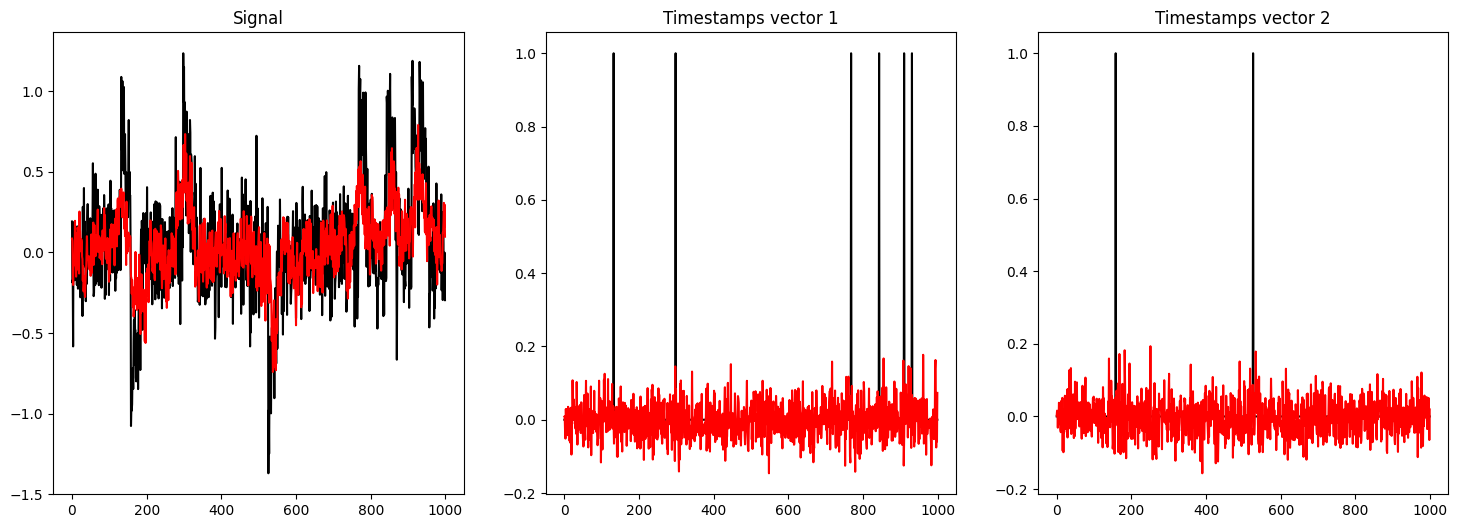

In [46]:
def inference(model, subset)-> Tuple[torch.Tensor, np.array, np.array]:
    x = get_random_data(subset)
    x_hat = model(x)
    return x,detach_to_np(x), detach_to_np(x_hat)



x_test_tensor, x_test, x_hat_test = inference(model, data_mod.test)


plot_data(x_test, x_hat_test)


## Lack of timestamp encoding asscoiated with overfitting

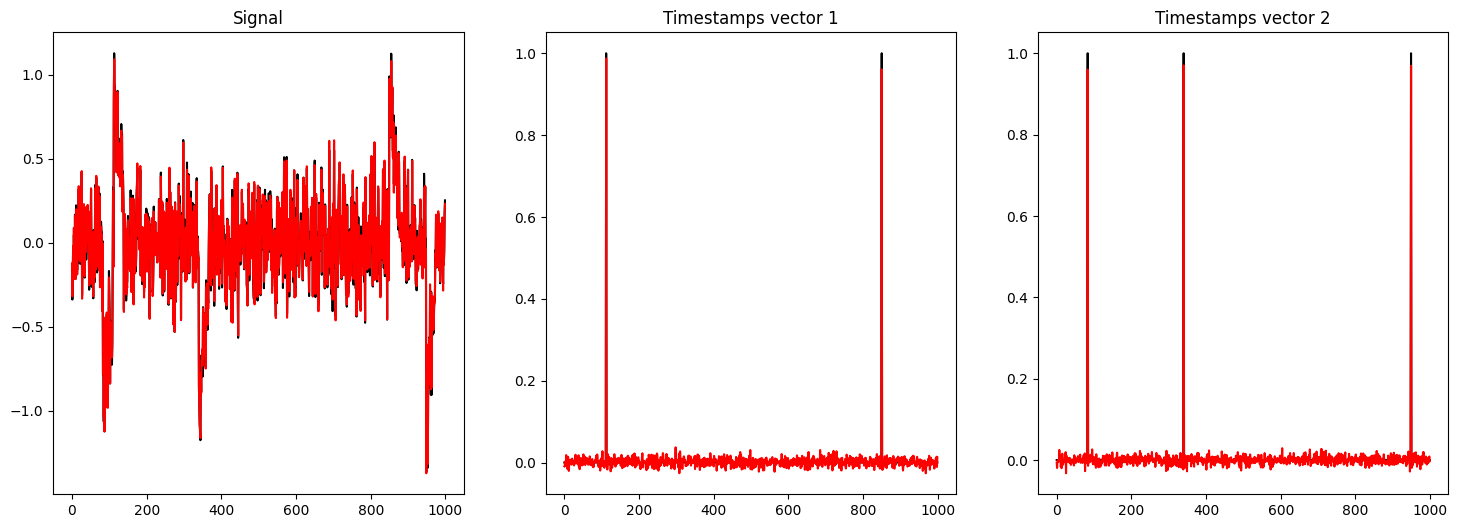

In [47]:
x_train_tensor, x_train, x_hat_train = inference(model, data_mod.train)
features = extractor.extract(x_train_tensor)
plot_data(x_train, x_hat_train)

In [75]:
numb_cols = features['cnn1'].shape[0]//4
num_rows = features['cnn1'].shape[0]//numb_cols
num_rows

4

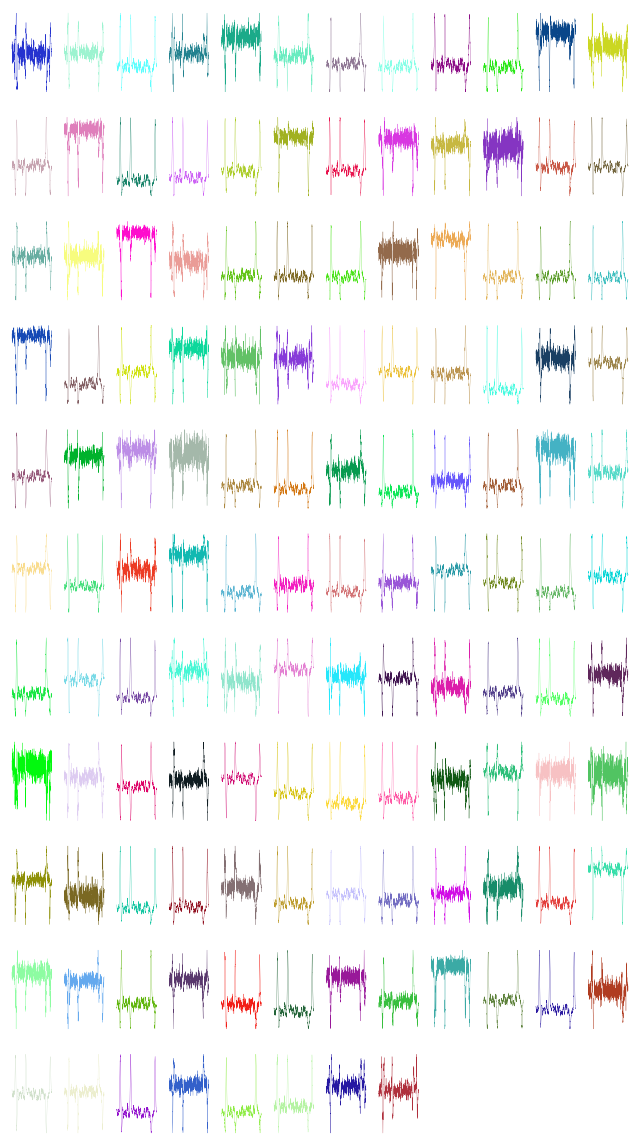

In [142]:

def generate_random_color():
    return "#{:06x}".format(np.random.randint(0, 0xFFFFFF))

def plot_layer(maps, nrows = 12, ncols = 12):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize =(8, 16))
    ax = ax.flatten() #flatten axis array
    for i, m in enumerate(maps):
        if i < len(maps):
            ax[i].plot(m, lw = 0.2, color = generate_random_color())
            ax[i].set_xticks([])
            ax[i].set_yticks([])

    for i in range(maps.shape[0], len(ax)):
        fig.delaxes(ax[i])

    sns.despine(top = True, bottom=True, left = True, right = True)
maps = features['cnn5']
ax = plot_layer(maps)

In [4]:
fp = torch.load('/Users/mds8301/Desktop/temp/aa_validation.pt')
samp = fp[0][0].detach().numpy()


In [56]:
from pywt import wavedec, waverec, threshold, wavelist

def wavelet_denoise(data, wavelet='bior3.1', level=1):
    coeff = wavedec(data, wavelet, mode="per")
    sigma = (1/0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level])))
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    coeff[1:] = (threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    return waverec(coeff, wavelet, mode="per")

wavelist(kind = 'discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [88]:
end_i = int(samp.shape[1]/4)
test = samp[0][:end_i][::100]
denoise = wavelet_denoise(test, wavelet ='bior2.1')
fig, ax = plt.subplots(nrows=2, figsize = (20, 5))
ax[0].plot(test, lw = 1)
ax[0].axhline(y = 1, linestyle = '--', linewidth = 0.5, color ='k')
ax[0].axhline(y = -1, linestyle = '--', linewidth = 0.5, color ='k')
ax[1].plot(denoise, lw = 1)
ax[1].axhline(y = 1, linestyle = '--', linewidth = 0.5, color ='k')
ax[1].axhline(y = -1, linestyle = '--', linewidth = 0.5, color ='k')

ValueError: Unknown wavelet name 'bior2.1', check wavelist() for the list of available builtin wavelets.

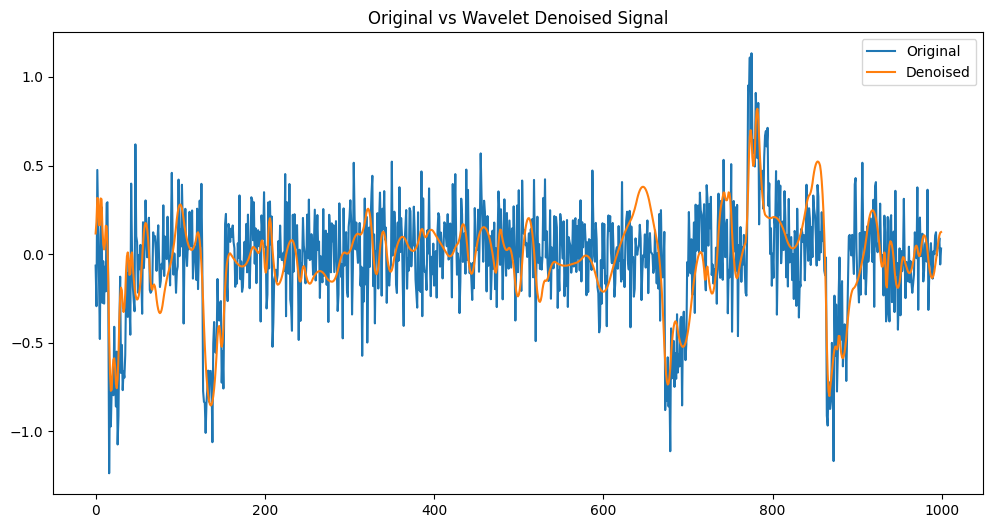

In [82]:


plt.figure(figsize=(12, 6))
plt.plot(arr[0], label='Original')
plt.plot(denoised_signal, label='Denoised')
plt.legend()
plt.title('Original vs Wavelet Denoised Signal')
plt.show()

In [90]:

plt.plot(samp)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x114275090>>
Traceback (most recent call last):
  File "/Users/mds8301/anaconda3/envs/transphorm/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
